# Защита персональных данных клиентов

Необходимо защитить данные клиентов страховой компании «Хоть потоп». Для этого разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуем корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span><ul class="toc-item"><li><span><a href="#Проверка-метрики-на-исходных-данных" data-toc-modified-id="Проверка-метрики-на-исходных-данных-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверка метрики на исходных данных</a></span></li><li><span><a href="#Проверка-метрики-на-преобразованных-данных" data-toc-modified-id="Проверка-метрики-на-преобразованных-данных-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Проверка метрики на преобразованных данных</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

RS = 12345
plt.rcParams["figure.figsize"] = (10, 6)
np.set_printoptions(suppress=True)
sns.set()

In [2]:
df = pd.read_csv('/datasets/insurance.csv')

Изучим первые 5 строк исходных данных:

In [3]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Основная информация о таблице:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Проверка на пропуски:

In [5]:
df.isna().sum()

Пол                  0
Возраст              0
Зарплата             0
Члены семьи          0
Страховые выплаты    0
dtype: int64

Проверка на дубликаты:

In [6]:
df.duplicated().sum() * 100 / len(df)

3.06

Избавимся от дубликатов:

In [7]:
df.drop_duplicates(inplace=True)

Исследуем распределения в данных:

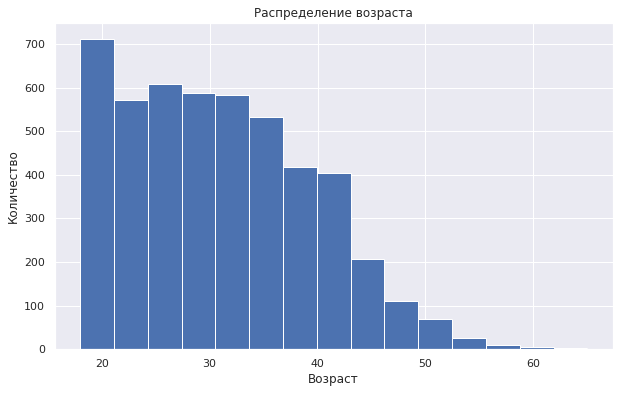

In [8]:
df['Возраст'].hist(bins=15)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста')
plt.show()

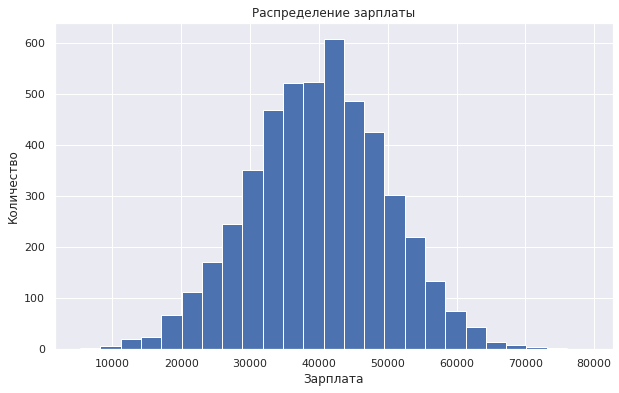

In [9]:
df['Зарплата'].hist(bins=25)
plt.xlabel('Зарплата')
plt.ylabel('Количество')
plt.title('Распределение зарплаты')
plt.show()

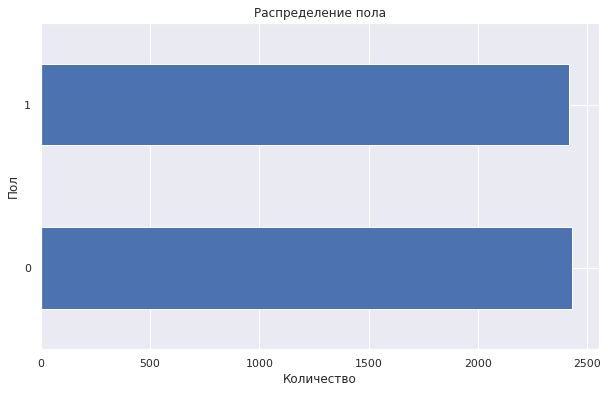

In [10]:
df['Пол'].value_counts().plot(kind='barh')
plt.title('Распределение пола')
plt.xlabel('Количество')
plt.ylabel('Пол')
plt.show()

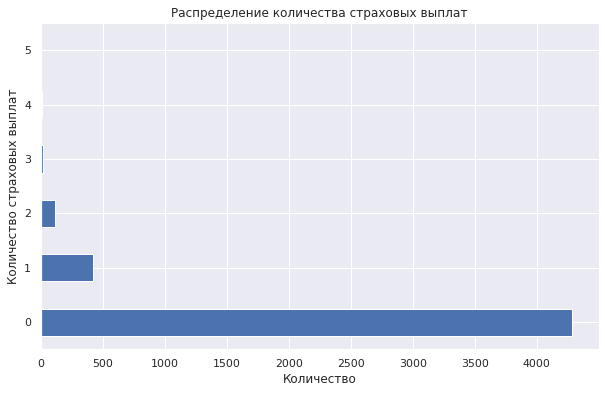

In [11]:
df['Страховые выплаты'].value_counts().plot(kind='barh')
plt.title('Распределение количества страховых выплат')
plt.xlabel('Количество')
plt.ylabel('Количество страховых выплат')
plt.show()

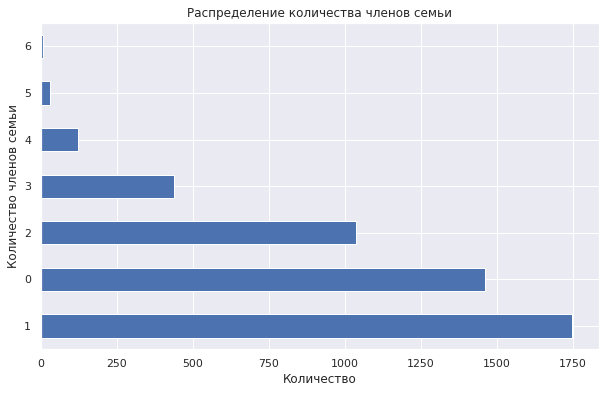

In [12]:
df['Члены семьи'].value_counts().plot(kind='barh')
plt.title('Распределение количества членов семьи')
plt.xlabel('Количество')
plt.ylabel('Количество членов семьи')
plt.show()

### Вывод

Данные загружены и изучены.

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Вопрос:**

Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

**Ответ:** 

Не изменится


**Обоснование:**

Воспользуемся следующими свойствами:
$$
AA^{-1} = A^{-1}A = E
$$

$$
AE = EA = A
$$

$$
(AB)^{-1} = B^{-1}A^{-1}
$$

$$
(AB)^{T} = B^{T}A^{T}
$$

Подставим вектор весов в формулу для предсказаний:

$$
a = X(X^{T}X)^{-1}X^{T}y
$$

$$
a = XX^{-1}(X^{T})^{-1}X^{T}y
$$

В конечном итоге все сводится к выражению:

$$
a = EEy = Ey
$$

Пусть $Z = XP$, где $P$ - обратимая матрица с некоторыми значениями. Тогда заменим матрицу признаков $X$ на $Z$ в исходных формулах и получим:

$$
a = Zw
$$

$$
w = (Z^{T}Z)^{-1}Z^{T}y
$$

Подставим вектор весов в выражение для вычисления вектора предсказаний:

$$
a = Z(Z^{T}Z)^{-1}Z^{T}y
$$

$$
a = ZZ^{-1}(Z^{T})^{-1}Z^{T}y
$$

Подставим $Z = XP$

$$
a = (XP)(XP)^{-1}((XP)^{T})^{-1}(XP)^{T}y
$$

$$
a = XX^{-1}PP^{-1}((XP)^{T})^{-1}(XP)^{T}y
$$

$$
a = XEX^{-1}(X^{T}P^{T})^{-1} X^{T}P^{T}y
$$

$$
a = XX^{-1}(X^{T})^{-1}(P^{T})^{-1} X^{T}P^{T}y
$$

$$
a = XX^{-1}(X^{T})^{-1}X^{T}y
$$

$$
a = X(X^{T}X)^{-1}X^{T}y
$$

$$
a = Xw
$$

### Вывод

Качество линейной регресии при умножении матрицы признаков на обратимую матрицу не меняется.

## Алгоритм преобразования

**Алгоритм**

Воспользуемся тем фактом, что исследуемая метрика не будет меняться при умножении матрицы признаков на обратимую матрицу.

1. Исследование метрики на исходных данных

1. Генерирование случайной матрицы 

2. Проверка матрицы не невырожденность

3. Получение матрицы преобразованных признаков

4. Исследование метрики на преобразованных данных

5. Сравнение полученных значений


**Обоснование**

Обоснование возможности применение данного преобразования приведено в п.2. Также необходимо учесть, что размерность случайной  матрицы должна иметь вид $n \times n$ для корректного умножения матриц.

### Вывод

Построен и обоснован алгоритм шифрования данных.

## Проверка алгоритма

### Проверка метрики на исходных данных

In [13]:
features = df.drop('Страховые выплаты', axis=1)
target = df['Страховые выплаты']

In [14]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=1)

In [15]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print(f'Метрика R2 на на исходных данных: {round(r2_score(target_test, predictions), 2)}')

Метрика R2 на на исходных данных: 0.46


### Проверка метрики на преобразованных данных

Функция `inv_matrix` принимает на вход матрицу признаков и возвращает случайную невырожденную матрицу необходимой размерности:

In [16]:
def inv_matrix(features):
    np.random.seed(0)
    n = features.shape[1]
    matrix = np.random.uniform(0, 100, size=(n, n))
    while np.linalg.det(matrix) == 0:
        matrix = np.random.uniform(0, 100, size=(n, n))
    return matrix

Преобразуем признаки:

In [17]:
features_transformed = features.values @ inv_matrix(features)

In [18]:
features.values

array([[    1.,    41., 49600.,     1.],
       [    0.,    46., 38000.,     1.],
       [    0.,    29., 21000.,     0.],
       ...,
       [    0.,    20., 33900.,     2.],
       [    1.,    22., 32700.,     3.],
       [    1.,    28., 40600.,     1.]])

In [19]:
features_transformed

array([[4781615.9625689 , 1904682.1778399 , 3928817.67639962,
        2627038.27252588],
       [3663924.10643698, 1460141.44412189, 3010575.14949175,
        2013911.5637946 ],
       [2024920.39597024,  807100.28246203, 1663891.58288626,
        1113265.47318337],
       ...,
       [3267777.67660939, 1301343.65637318, 2684837.2607344 ,
        1794754.74982385],
       [3152334.56211563, 1255623.93153716, 2589985.15355016,
        1731528.91530193],
       [3913768.72687883, 1558745.14854971, 3215696.27875058,
        2149873.53984725]])

In [20]:
features_train, features_test, target_train, target_test = train_test_split(features_transformed, target, test_size=0.25, random_state=1)

In [21]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print(f'Метрика R2 на на преобразованных данных: {round(r2_score(target_test, predictions), 2)}')

Метрика R2 на на преобразованных данных: 0.46


### Вывод

Алгоритм преобразования проверен на практике. Полученные результаты совпадают с теоретическими.

## Общий вывод

Таким образом, был изучен вопрос влияния на исследуемую метрику процедура умножения матрицы признаков на обратимую. Удалось выяснить, что данное действие не оказывает влияние на итоговую метрику. Полученный результат исследования был применен в алгоритме шифрования пользовательских данных, который на практике показал результаты исследования.